# Test Notebook - Microtubule Project
Author: Bettina Vignolo

This notebook aims to test a few changes to the original code written by Valentin and moreover test some ideas for analysis. 

**Possible changes might include:**
- simpler syntax
- plotting aesthetics
- using count() instead of StatsBase Pkg
- using seeds similar to publication (not single seeds but longer ones and with different color)
- 3 Dimensions
- different growth directions (and possibility to cross) as seen in publication

**General questions to be solved:**
- Translation of experiment to modell:  What are realistic ranges for our parameters?
- how are realistic timesteps defined? which dimensions and tubulin concentrations should be chosen for parameter sweep?
- how can the runtime be improved? what data do we really need for analysis?

## 1. Loading Packages and Functions:

In [1]:
# load Packages:

using Agents
using Statistics
using DataFrames
using Distributions
using StatsBase
using DrWatson: @dict
using Serialization
using InteractiveDynamics
using GLMakie
import ColorSchemes as co
using DataFramesMeta


# load Functions: 
#include("functions/init.jl")
#include("functions/agentstep.jl")
#include("functions/agent.jl")
#include("functions/analysis_funs.jl")
#include("functions/modelstep.jl")
include("01_Agent.jl")
include("02_Initialization.jl")
include("03_AgentStep.jl")
include("04_ModelStep.jl")
include("05_Analysis.jl")

MT_size_each (generic function with 1 method)

In [ ]:
using Distributed
addprocs(4)

@everywhere begin
    # load Packages:
    using Agents
    using Statistics
    using DataFrames
    using Distributions
    using StatsBase
    using DrWatson: @dict
    using Serialization
    using InteractiveDynamics
    using GLMakie
    import ColorSchemes as co
    using DataFramesMeta

    # load Functions:
    include("01_Agent.jl")
    include("02_Initialization.jl")
    include("03_AgentStep.jl")
    include("04_ModelStep.jl")
    include("05_Analysis.jl")
end    

## 2. Main Functions (and possible changes)

### 2.1 Agent (agent.jl)
Ideas for changing:
- Must be adapted for 3D

In [2]:
@agent tubulin GridAgent{2} begin
    polym::Int64
    GDP::Bool
end

### 2.2 Initialization (init.jl)

#### Ideas for change:
- Probabilities:
    - <s> P_depolym_GDP is the contrary of p_depolym_GDP in this code -> for me confusing; should be read as "Probability to depolymerize if tubulin has GDP bound" and thus also changed in the AgentStep Code? </s>
    
    - <s>Additional probability to be incl. "P_GDP_GTP_exchange" (only for free agents), in experiment this is dependent on free GTP concentrations and should decline during experiment if GTP is not added constantly to the system. Only if GDP to GTP exchange is possible, then agents can be reincorporated into a MT after depolymerizing </s>
    
    

- Populating the grid with agents:
    - <s> Why should the first seed always be in the middle of the grid? could they all be added to random positions? </s> (implemented)
    - <s> Shorter alternative for populating the grid with agents </s> (implemented)
    - Avoid collisions: populating Nstarts -> check if other agent is positioned at same diagonale and if so change position and check again

In [27]:
function initialize(;Nstarts::Int64, numagents::Int64, periodic::Bool, griddims::Tuple{Int64,Int64}, p_hyd::Float64,  p_polym::Float64,
                        p_depolym_GTP::Float64, p_depolym_GDP::Float64, p_GTP_exchange::Float64)
   
    P_hyd = Binomial(1,p_hyd)                       # Prob to hydrolize from GTP to GDP:  GTPase rate
    P_polym = Binomial(1,p_polym)                   # Prob to Polymerize/bind to the microtuble 
    P_depolym_GTP = Binomial(1,p_depolym_GTP)       # Prob to depolimerize if not hydrolized (GTP - tubulin) = lower
    P_depolym_GDP = Binomial(1,p_depolym_GDP)       # Prob to depolimerize if hydrolized (GDP - tubulin) = higher
    P_GTP_exchange = Binomial(1,p_GTP_exchange)     # Prob to exchange GDP to GTP
    
    properties = @dict griddims numagents Nstarts p_depolym_GTP p_depolym_GDP p_polym p_hyd p_GTP_exchange P_hyd P_polym P_depolym_GTP P_depolym_GDP P_GTP_exchange
      
    properties[:tick] = 0

    space = GridSpace(griddims, periodic = periodic )   # define Gridspace with dimensions and if periodic = true or false
    
    model = ABM(tubulin, space;                         # create model using Agents.ABM
        scheduler = Schedulers.randomly,                # activates all agents once per step in a random order
        properties = properties )
    
    #  populating Grid Space with Agents  
    for i in 1:Nstarts                              # Startingpoints
        agent = tubulin(i,(1,1),i,true)        # first agent with id = 1, positioned at , microtubulus id = 1, hydrolized status = true
        add_agent_single!(agent, model)             # add at random location
    end

    for i in Nstarts+1:numagents
        agent =  tubulin(i,(1,1),0,false)           # rest of agents are unpolymerized (polym=0) and not hydrolized (GDP = false)
        add_agent_single!(agent, model)             # add agents to random positions
    end

    return model
end

initialize (generic function with 1 method)

### 2.3 Agentstep (agentstep.jl) 

#### Ideas for change:

-<s> ```rand(model.P_depolym_GDP,1)[1] ``` should be the same as ``` rand(model.P_depolym_GDP) ``` </s>(implemented)

-<s> If P_depolym_GDP is changed from 1 - p_depolym_GDP to p_depolym_GDP, the ```if else ``` condition must be changed as well  </s>(implemented)

-<s> Adding GDP-GTP exchange for free tubulin (polym == 0)   </s>(implemented)


In [4]:
function agent_step!(agent,model)
# for all free agents (which are not the starting points in the beginning)
    if agent.id > model.Nstarts && agent.polym == 0           # only agents that are not starting points and are not yet polymerized    

        walk!(agent, rand, model, ifempty = true)             # agent walks +/-1 Position in random direction but only if this location is empty
        
        if agent.GDP 
            agent.GDP = rand(model.P_GTP_exchange) == 1 ? false : true #if GDP is bound, it is decided if it will be eschanged to GTP
        end
        
        for id in nearby_ids(agent, model, 1)                # for all other agents right next to agent (r = 1 is the distance)
            if model[id].polym > 0  && model[id].pos == collect(nearby_positions(agent, model,1))[8]  # if agent at the upper right corner ([8]) is polymerized
                agent.polym = rand(model.P_polym) == 1 ? model[id].polym : 0 
                # if rand() == 1 then the agent receives the MT id of neighbor[8] otherwise it stays at 0 (agents is still not polymerized)
            end
        end
    end
    
# for all polymerized agents (which are not the starting points):
    if agent.polym > 0 && agent.id > model.Nstarts            
        if agent.GDP == false                   # if GTP is bound               
            agent.GDP = rand(model.P_hyd)       # GTP gets hydrolyzed with the probability of p_hyd 
            # rand(...) results in either 1 or 0 which can also be interpreted as true or false  
        end
        
        if isempty(collect(nearby_positions(agent, model,1))[1], model)           # checks if nearby position at lower left corner ([1]) is empty
            if agent.GDP                                                          # if GDP is bound
                agent.polym = rand(model.P_depolym_GDP) == 1  ? 0 : agent.polym   
                # if rand(...) == 1 the agent depolymerizes (agent.polym = 0), else the agent.polym stays the same
            else                                                                  # if GTP is bound
                agent.polym = rand(model.P_depolym_GTP) == 1  ? 0 : agent.polym   
                # if rand(...) == 1 the agent depolymerizes (agent.polym = 0), else the agent.polym stays the same
            end
        end
   end
end

agent_step! (generic function with 1 method)

### 2.4 Modelstep (modelstep.jl)

Ideas for change:
<strike> - As mentioned below the Init.jl function: shouldn't P_hyd be 1 after polymerization? shouldn't P_depolym_GTP be 0? (implemented) <strike>

In [10]:
function model_step!(model)
    model.tick += 1                                            # represents time marker
    model.P_hyd = Binomial(1,model.p_hyd)                      # Prob to hydrolize from GTP to GDP: 
    model.P_polym = Binomial(1,model.p_polym)                  # Prob to Polymerize/bind to the microtubule 
    model.P_depolym_GTP = Binomial(1,model.p_depolym_GTP)      # Prob to depolimerize if not hydrolized (GTP - tubulin) = lower
    model.P_depolym_GDP = Binomial(1,model.p_depolym_GDP)      # Prob to depolimerize if hydrolized (GDP - tubulin) = higher
    model.P_GTP_exchange = Binomial(1,model.p_GTP_exchange)    # Prob to exchange GDP to GTP
end

model_step! (generic function with 1 method)

## 3. Visualizations and Analysis
### 3.1 Initial or after specific step



In [12]:
#Initialize Model
model=initialize(; Nstarts = 4,
        periodic = true,
        numagents = 1000,
        griddims = (100,100), 
        p_polym = 1.0,
        p_hyd = 0.024,
        p_GTP_exchange = 0.01,
        p_depolym_GTP = 0.0,
        p_depolym_GDP = 0.2)

# aesthetics
groupcolor(a) = a.polym == 0 ? :blue : a.id <= model.Nstarts ? :red : :green 
groupmarker(a) = a.GDP == true ? '●' : '○'
# figure
fig,stepper = abm_plot(model, ac=groupcolor, am=groupmarker)

fig

In [14]:
#let the model run to progress the ABM plot:
Agents.step!(stepper, model, agent_step!, model_step!, 9000)
display(fig)

GLMakie.Screen(...)

### 3.1.2 Running model with fixed parameters and collecting data

In [18]:
model=initialize(; Nstarts = 5,
        periodic = true,
        numagents = 500,
        griddims = (50,50), 
        p_polym = 0.5,
        p_hyd = 0.01,
        p_GTP_exchange = 0.005,
        p_depolym_GTP = 0,
        p_depolym_GDP = 0.25)
#vector initialzed
mdata = [mean_MT_size, MT_size_1, MT_size_2, MT_size_3, MT_size_4, MT_size_5]
#adata = [:pos, :polym, :GDP]

#running the model and data collection
modeldata = run!(model,agent_step!,model_step!, 3600; mdata)

(0×0 DataFrame, 3601×7 DataFrame
  Row │ step   mean_MT_size  MT_size_1  MT_size_2  MT_size_3  MT_size_4  MT_si ⋯
      │ Int64  Float64       Int64      Int64      Int64      Int64      Int64 ⋯
──────┼─────────────────────────────────────────────────────────────────────────
    1 │     0           1.0          1          1          1          1        ⋯
    2 │     1           1.0          1          1          1          1
    3 │     2           1.0          1          1          1          1
    4 │     3           1.0          1          1          1          1
    5 │     4           1.2          2          1          1          1        ⋯
    6 │     5           1.2          2          1          1          1
    7 │     6           1.2          2          1          1          1
    8 │     7           1.2          2          1          1          1
    9 │     8           1.6          2          1          3          1        ⋯
   10 │     9           1.6          2          1

In [19]:
serialize("data/MT size_0.005GTP_0.025depolym_0.01hyd_500numag_3600 steps.jls", modeldata)

### 3.2.1 Interactive - abm_play()


In [4]:
#Initialize Model
model=initialize(; Nstarts = 5,
        periodic = true,
        numagents = 1000,
        griddims = (100,100), 
        p_polym = 1,
        p_hyd = 0.02,
        p_GTP_exchange = 0.015,
        p_depolym_GTP = 0,
        p_depolym_GDP = 0.3) 
# aesthetics
groupcolor(a) = a.polym == 0 ? :blue : a.id <= model.Nstarts ? :red : :green 
groupmarker(a) = a.GDP == true ? '●' : '○'
# figure
fig2, stepper = abm_play(model, agent_step!, model_step!, ac=groupcolor, am=groupmarker)


(Scene (600px, 700px):
  29 Plots:
    ├ Combined{Makie.poly, Tuple{Vector{Vector{Point{2, Float32}}}}}
    ├ LineSegments{Tuple{Vector{Point{2, Float32}}}}
    ├ LineSegments{Tuple{Vector{Point{2, Float32}}}}
    ├ LineSegments{Tuple{Vector{Point{2, Float32}}}}
    ├ LineSegments{Tuple{Vector{Point{2, Float32}}}}
    ├ LineSegments{Tuple{Vector{Point{2, Float32}}}}
    ├ LineSegments{Tuple{Vector{Point{2, Float32}}}}
    ├ MakieCore.Text{Tuple{String}}
    ├ Lines{Tuple{Vector{Point{2, Float32}}}}
    ├ MakieCore.Text{Tuple{Vector{Tuple{AbstractString, Point{2, Float32}}}}}
    ├ LineSegments{Tuple{Vector{Point{2, Float32}}}}
    ├ LineSegments{Tuple{Vector{Point{2, Float32}}}}
    ├ MakieCore.Text{Tuple{String}}
    ├ Lines{Tuple{Vector{Point{2, Float32}}}}
    ├ MakieCore.Text{Tuple{Vector{Tuple{AbstractString, Point{2, Float32}}}}}
    ├ Lines{Tuple{Vector{Point{2, Float32}}}}
    ├ Lines{Tuple{Vector{Point{2, Float32}}}}
    ├ MakieCore.Text{Tuple{String}}
    ├ Combined{Makie._in

### 3.2.2 Interactive - abm_data_exploration()

In [4]:
#Initialize Model
model=initialize(; Nstarts = 5,
        periodic = true,
        numagents = 1000,
        griddims = (100,100), 
        p_polym = 1,
        p_hyd = 0.02,
        p_GTP_exchange = 0.015,
        p_depolym_GTP = 0,
        p_depolym_GDP = 0.3) 

#define variable parameters
params = Dict(
    :numagents => 0:50:5000,
    :p_hyd => 0:0.01:1,
    :p_depolym_GDP => 0:0.01:1,
    :p_GTP_exchange => 0:0.01:1
)
# aesthetics
groupcolor(a) = a.polym == 0 ? :blue : a.id <= model.Nstarts ? :red : :green 
groupmarker(a) = a.GDP == true ? '●' : '○'
# data that will be collected during exploration and plotted in the interactive plot
mdata = [mean_MT_size, MT_size_1, MT_size_2, MT_size_3, MT_size_4, MT_size_5]
mlabels =["mean MT length", "MT 1", "MT 2", "MT 3", "MT 4", "MT 5"]

fig3, adf, mdf = abm_data_exploration(
    model, agent_step!, model_step!, params;
    ac = groupcolor, am = groupmarker, mdata, mlabels
)

(Scene (1600px, 800px):
  157 Plots:
    ├ Combined{Makie.poly, Tuple{Vector{Vector{Point{2, Float32}}}}}
    ├ LineSegments{Tuple{Vector{Point{2, Float32}}}}
    ├ LineSegments{Tuple{Vector{Point{2, Float32}}}}
    ├ LineSegments{Tuple{Vector{Point{2, Float32}}}}
    ├ LineSegments{Tuple{Vector{Point{2, Float32}}}}
    ├ LineSegments{Tuple{Vector{Point{2, Float32}}}}
    ├ LineSegments{Tuple{Vector{Point{2, Float32}}}}
    ├ MakieCore.Text{Tuple{String}}
    ├ Lines{Tuple{Vector{Point{2, Float32}}}}
    ├ MakieCore.Text{Tuple{Vector{Tuple{AbstractString, Point{2, Float32}}}}}
    ├ LineSegments{Tuple{Vector{Point{2, Float32}}}}
    ├ LineSegments{Tuple{Vector{Point{2, Float32}}}}
    ├ MakieCore.Text{Tuple{String}}
    ├ Lines{Tuple{Vector{Point{2, Float32}}}}
    ├ MakieCore.Text{Tuple{Vector{Tuple{AbstractString, Point{2, Float32}}}}}
    ├ Lines{Tuple{Vector{Point{2, Float32}}}}
    ├ Lines{Tuple{Vector{Point{2, Float32}}}}
    ├ MakieCore.Text{Tuple{String}}
    ├ Combined{Makie._

In [53]:
serialize("data/MT size_0.01GTP_0.5depolym_0.02hyd_1000numag_1800 steps.jls", mdf)

### 3.3 Analysis

In [16]:
# Initialize vectors for model df and agent df :
mdata = [:p_hyd, mean_MT_size, sd_MT_size, free_tubulin, polym_tubulin, MT_size_each]
adata = [:pos, :polym, :GDP]

# Run the model:
data = run!(model, agent_step!, model_step!, 10000; adata, mdata)

# Save the data inside ./data
serialize("data/single_model1.jls", data)

# for convienence:
agentdata = data[1]; 
modeldata = data[2];

# show Model Data:
modeldata

,step,p_hyd,mean_MT_size,sd_MT_size,free_tubulin,polym_tubulin,MT_size_each
,Int64,Float64,Float64,Float64,Int64,Int64,Array…
1,0,0.02,1.0,NaN,999,1,[1]
2,1,0.02,1.0,NaN,999,1,[1]
3,2,0.02,1.0,NaN,999,1,[1]
4,3,0.02,1.0,NaN,999,1,[1]
5,4,0.02,1.0,NaN,999,1,[1]
6,5,0.02,1.0,NaN,999,1,[1]
7,6,0.02,1.0,NaN,999,1,[1]
8,7,0.02,1.0,NaN,999,1,[1]
9,8,0.02,1.0,NaN,999,1,[1]


Figure f1 shows MT size over time

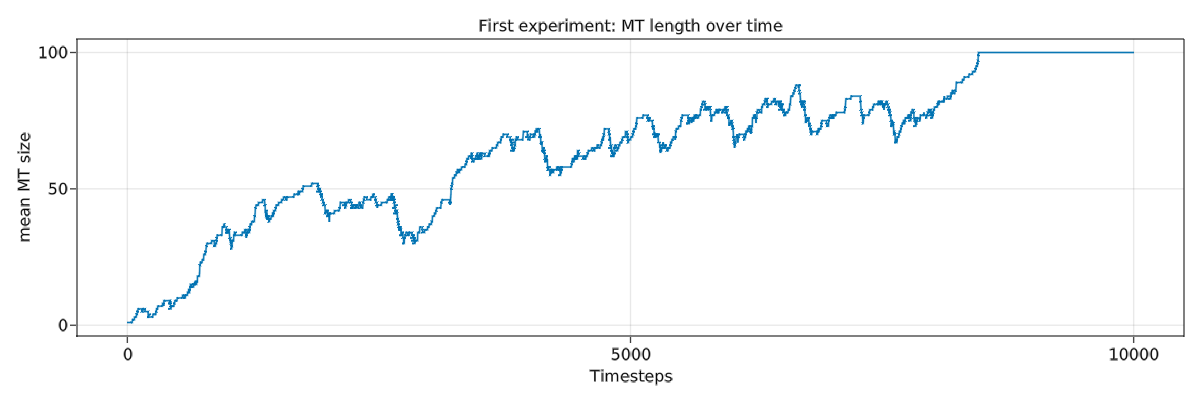

In [38]:
f1 = Figure(resolution =(1200,400))
delete!(ax1)
ax1 = Axis(f1[1,1]; xlabel = "Timesteps", ylabel = "mean MT size", title = "First experiment: MT length over time")
liney = lines!(ax1, modeldata.step, modeldata.mean_MT_size) 
f1

Figure f2 displays number of free tubulin vs polymerized tubulin over time

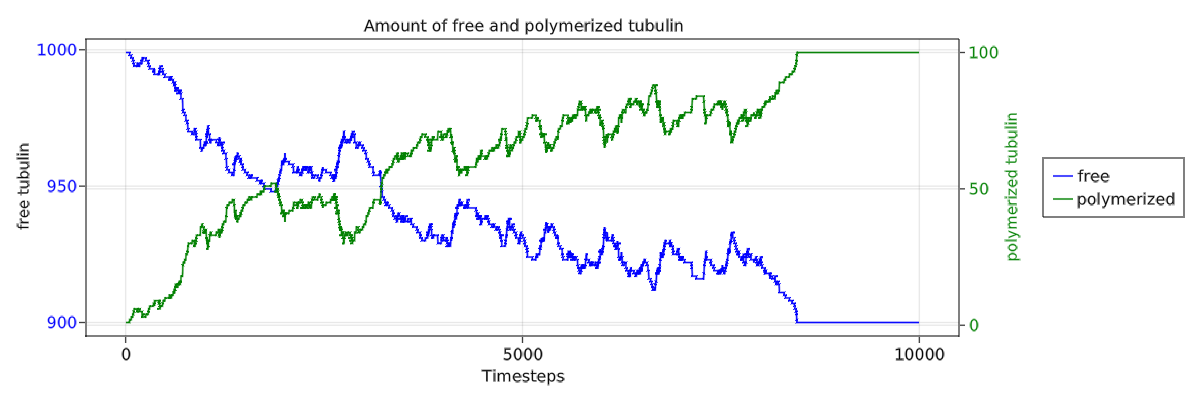

In [26]:
f2 = Figure(resolution = (1200, 400))
ax2_1 = Axis(f2[1,1], xlabel = "Timesteps", ylabel = "free tubulin", ylabelsize = 15, yticklabelcolor = :blue, title = "Amount of free and polymerized tubulin")
ax2_2 = Axis(f2[1, 1], yticklabelcolor = :green, yaxisposition = :right, ylabel = "polymerized tubulin", ylabelsize = 15, ylabelcolor = :green)
hidespines!(ax2_2)
hidexdecorations!(ax2_2)


liney1 = lines!(ax2_1, modeldata.step, modeldata.free_tubulin, color = :blue, label = "free")
liney2 = lines!(ax2_2, modeldata.step, modeldata.polym_tubulin, color = :green, label = "polymerized")

Legend(f2[1,2], [liney1, liney2], ["free", "polymerized"])

f2

### 3.4 Parameter Scan

In [13]:
# Scanning  parameters
parameters=Dict(
            :griddims => (100,100),
            :periodic => true,
            :Nstarts => 3,
            :numagents => 1000, 
            :p_hyd => 0.02,                   
            :p_polym=> 1 ,    
            :p_depolym_GTP => 0,
            :p_depolym_GDP => collect([0:0.2:1]...),
            :p_GTP_exchange => 0.01
    ) 

# Model Data:
# adata = [:pos, :polym, :GDP]
mdata = [mean_MT_size, sd_MT_size]
mlabels=["mean MT length", "sd"]

# Run Model 
_ , paramdata = paramscan(parameters, initialize;  mdata, agent_step!, model_step!, n=10000) # we don't need adata in this case thus _ , paramdata
serialize("data/paramscan_p_depolym_GDP_2.jls", paramdata)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:48


(6×1 DataFrame
 Row │ p_depolym_GDP 
     │ Float64       
─────┼───────────────
   1 │           0.0
   2 │           0.2
   3 │           0.4
   4 │           0.6
   5 │           0.8
   6 │           1.0, 60006×4 DataFrame
   Row │ step   mean_MT_size  sd_MT_size  p_depolym_GDP 
       │ Int64  Float64       Float64     Float64       
───────┼────────────────────────────────────────────────
     1 │     0       1.0         0.0                0.0
     2 │     1       1.0         0.0                0.0
     3 │     2       1.33333     0.57735            0.0
     4 │     3       1.66667     0.57735            0.0
     5 │     4       1.66667     0.57735            0.0
     6 │     5       2.0         1.0                0.0
     7 │     6       2.0         1.0                0.0
     8 │     7       2.0         1.0                0.0
     9 │     8       2.0         1.0                0.0
    10 │     9       2.0         1.0                0.0
    11 │    10       2.0         1.0       

### 3.5 Test with growth rates on each MT level

In [ ]:

function MT_size_1(model)
    MT_size_1 = count(i->(i==1), [model.agents[i].polym for i in 1:length(model.agents)])
end

function MT_size_2(model)
    MT_size_2 = count(i->(i==2), [model.agents[i].polym for i in 1:length(model.agents)])
end

function MT_size_3(model)
    MT_size_3 = count(i->(i==3), [model.agents[i].polym for i in 1:length(model.agents)])
end

function MT_size_4(model)
    MT_size_4 = count(i->(i==4), [model.agents[i].polym for i in 1:length(model.agents)])
end

function MT_size_5(model)
    MT_size_5 = count(i->(i==5), [model.agents[i].polym for i in 1:length(model.agents)])
end

In [4]:
parameters=Dict(
            :griddims => (100,100),
            :periodic => true,
            :Nstarts => 2,
            :numagents => 1000, 
            :p_hyd => 0.02,                   
            :p_polym=> 1.0 ,    
            :p_depolym_GTP => 0.0,
            :p_depolym_GDP => collect([0.0:0.2:1.0]...),
            :p_GTP_exchange => 0.01
    ) 

# Model Data:
# adata = [:pos, :polym, :GDP]
mdata = [mean_MT_size, MT_size_each]
mlabels=["mean MT length", "MT_size_each"]

# Run Model 
_ , paramdata = paramscan(parameters, initialize;  mdata, agent_step!, model_step!, n=10000)

Progress: 100%|█████████████████████████████████████████| Time: 0:01:12


(6×1 DataFrame
 Row │ p_depolym_GDP 
     │ Float64       
─────┼───────────────
   1 │           0.0
   2 │           0.2
   3 │           0.4
   4 │           0.6
   5 │           0.8
   6 │           1.0, 60006×4 DataFrame
   Row │ step   mean_MT_size  MT_size_each  p_depolym_GDP 
       │ Int64  Float64       Array…        Float64       
───────┼──────────────────────────────────────────────────
     1 │     0           1.0  [1, 1]                  0.0
     2 │     1           1.0  [1, 1]                  0.0
     3 │     2           1.5  [1, 2]                  0.0
     4 │     3           1.5  [1, 2]                  0.0
     5 │     4           1.5  [1, 2]                  0.0
     6 │     5           1.5  [1, 2]                  0.0
     7 │     6           1.5  [1, 2]                  0.0
     8 │     7           1.5  [1, 2]                  0.0
     9 │     8           1.5  [1, 2]                  0.0
    10 │     9           1.5  [1, 2]                  0.0
    11 │    10   

In [5]:
serialize("data/paramscan_p_depolym_GDP_eachMTsize_test.jls", paramdata)

In [2]:
data = deserialize("data/paramscan_p_depolym_GDP_eachMTsize_test.jls")

,step,mean_MT_size,MT_size_each,p_depolym_GDP
,Int64,Float64,Array…,Float64
1,0,1.0,"[1, 1]",0.0
2,1,1.0,"[1, 1]",0.0
3,2,1.5,"[1, 2]",0.0
4,3,1.5,"[1, 2]",0.0
5,4,1.5,"[1, 2]",0.0
6,5,1.5,"[1, 2]",0.0
7,6,1.5,"[1, 2]",0.0
8,7,1.5,"[1, 2]",0.0
9,8,1.5,"[1, 2]",0.0


### 3.6 Experiment: Single MT growth to analyze catastrophes
First try in this notebook. This topic was later continued in a separate notebook called "Analysis 08 - Growth Rate"

In [17]:
parameters=Dict(
            :griddims => (100,100),
            :periodic => true,
            :Nstarts => 1,
            :numagents => 1000, 
            :p_hyd => 0.02,                   
            :p_polym=> 1.0 ,    
            :p_depolym_GTP => 0.0,
            :p_depolym_GDP => collect([0.0:0.2:1.0]...),
            :p_GTP_exchange => 0.01
    ) 

# Model Data:
# adata = [:pos, :polym, :GDP]
mdata = [mean_MT_size]
mlabels=["mean MT length"]

# Run Model 
_ , paramdata = paramscan(parameters, initialize;  mdata, agent_step!, model_step!, n=10000)

Progress: 100%|█████████████████████████████████████████| Time: 0:01:08


(6×1 DataFrame
 Row │ p_depolym_GDP 
     │ Float64       
─────┼───────────────
   1 │           0.0
   2 │           0.2
   3 │           0.4
   4 │           0.6
   5 │           0.8
   6 │           1.0, 60006×3 DataFrame
   Row │ step   mean_MT_size  p_depolym_GDP 
       │ Int64  Float64       Float64       
───────┼────────────────────────────────────
     1 │     0           1.0            0.0
     2 │     1           1.0            0.0
     3 │     2           1.0            0.0
     4 │     3           1.0            0.0
     5 │     4           2.0            0.0
     6 │     5           2.0            0.0
     7 │     6           2.0            0.0
     8 │     7           2.0            0.0
     9 │     8           2.0            0.0
    10 │     9           2.0            0.0
    11 │    10           2.0            0.0
   ⋮   │   ⋮         ⋮              ⋮
 59997 │  9991          23.0            1.0
 59998 │  9992          23.0            1.0
 59999 │  9993          23.0 

In [18]:
serialize("data/paramscan_p_depolym_GDP_oneMTsize_test.jls", paramdata)

In [5]:
data = deserialize("data/paramscan_p_depolym_GDP_oneMTsize_test.jls")

,step,mean_MT_size,p_depolym_GDP
,Int64,Float64,Float64
1,0,1.0,0.0
2,1,1.0,0.0
3,2,1.0,0.0
4,3,1.0,0.0
5,4,2.0,0.0
6,5,2.0,0.0
7,6,2.0,0.0
8,7,2.0,0.0
9,8,2.0,0.0


In [6]:
function growth_rate!(df) 
    df.growthrate = zeros(nrow(df))
    for n in 2:nrow(df)
        if df.step[n] == 0
            df.growthrate[n]=0
        elseif df.step[n]>0
            df.growthrate[n]= df[n,:mean_MT_size]-df[n-1,:mean_MT_size]
        end
    end
end

growth_rate! (generic function with 1 method)

In [7]:
growth_rate!(data)
data

,step,mean_MT_size,p_depolym_GDP,growthrate
,Int64,Float64,Float64,Float64
1,0,1.0,0.0,0.0
2,1,1.0,0.0,0.0
3,2,1.0,0.0,0.0
4,3,1.0,0.0,0.0
5,4,2.0,0.0,1.0
6,5,2.0,0.0,0.0
7,6,2.0,0.0,0.0
8,7,2.0,0.0,0.0
9,8,2.0,0.0,0.0


#### MT Length over time

In [49]:
f1 = Figure(resolution =(1200, 600))
ax1_1 = Axis(f1[1,1]; xlabel = "Timesteps", ylabel = "MT size", title = "MT size over time", yticks=LinearTicks(10))
#ax1_2 = Axis(f1[2,1]; xlabel = "Timesteps", ylabel = "MT growth rate", title = "MT growth rate over time")

range = collect(0.0:0.2:1.0)


for (i,v) in enumerate(range)
    sub_df = @subset(data, :p_depolym_GDP .== v)
    lines!(ax1_1, sub_df.step, sub_df.mean_MT_size, label = "$v", color = co.tab10[i])
    #lines!(ax1_2, sub_df.step, sub_df.growthrate, label = "$v", color = co.tab10[i])
end 
for i in collect(0:200:10000)
    vlines!(ax1_1, i, color = :black)
end


legend = Legend(f1[2,1], ax1_1, "p_depolym_GDP", orientation = :horizontal, tellwidth = false, tellheight = true)
f1

#### Counting number of +1, -1 and 0 in 250 step sections for p_depolym_GDP = 0.4

In [14]:
#count number of +1, -1 and 0 in each 250 step section
sub_df_04 = @subset(data, :p_depolym_GDP .== 0.4)
sub_df_04.growthclass = zeros(nrow(sub_df_04))

for i in collect(1:250:9751)
    section = collect(i:i+249)
    count_plus = count(x -> (x == 1.0), sub_df_04.growthrate[section])
    count_minus = count(x -> (x == -1.0), sub_df_04.growthrate[section])
    count_equal = count(x -> (x == 0.0), sub_df_04.growthrate[section])
    growthclass = count_minus >= 20 ? -1.0 : count_plus >= 3 ? 1.0 : 0.0

    for n in section
        sub_df_04.growthclass[n] = growthclass
    end
end

In [34]:
count_plus = count(x -> (x == 1.0), sub_df_04.growthclass)
count_minus = count(x -> (x == -1.0), sub_df_04.growthclass)
count_equal = count(x -> (x == 0.0), sub_df_04.growthclass)
println(count_plus/10001)
println(count_minus/10001)
println(count_equal)

0.5749425057494251
0.42495750424957507
1


In [40]:
#plot growthclass + MT length

f1_2 = Figure(resolution =(1200, 800))
ax1_2 = Axis(f1_2[1,1:2]; xlabel = "Timesteps", ylabel = "MT size", title = "MT size over time (p_depolym_GDP = 0.4)", yticks=LinearTicks(10))
ax1_2_2 = Axis(f1_2[2,1]; title = "Pie Chart", autolimitaspect = 1)
hidedecorations!(ax1_2_2)

for i in collect(1:250:9751)
    vlines!(ax1_2, i, color = (:black, 0.5))
end

for i in collect(1:250:9751)
    if sub_df_04.growthclass[i] == -1.0
        vspan!(ax1_2, i, i+249, color = (:red, 0.5), label = "catastrophe")
    elseif sub_df_04.growthclass[i] == 1.0
        vspan!(ax1_2, i, i+249, color = (:green, 0.5), label = "growth")
    end
end


lines!(ax1_2, sub_df_04.step, sub_df_04.mean_MT_size, label = "MT length", color = :black)
pie!(ax1_2_2, [count_plus, count_minus], color = [:green, :red])

legend = Legend(f1_2[2,2], ax1_2, tellwidth = false, tellheight = false, merge = true)
axislegend(ax1_2_2, [PolyElement(color = :green), PolyElement(color = :red)], ["57.5%", "42.5%"])
f1_2

#### Counting number of +1, -1 and 0 in 250 step sections for p_depolym_GDP = 0.8

In [42]:
#count number of +1, -1 and 0 in each 200 step section
sub_df_08 = @subset(data, :p_depolym_GDP .== 0.8)
sub_df_08.growthclass = zeros(nrow(sub_df_08))

for i in collect(1:250:9751)
    section = collect(i:i+249)
    count_plus = count(x -> (x == 1.0), sub_df_08.growthrate[section])
    count_minus = count(x -> (x == -1.0), sub_df_08.growthrate[section])
    count_equal = count(x -> (x == 0.0), sub_df_08.growthrate[section])
    growthclass = count_minus >= 20 ? -1.0 : count_plus >= 3 ? 1.0 : 0.0

    for n in section
        sub_df_08.growthclass[n] = growthclass
    end
end
count_plus = count(x -> (x == 1.0), sub_df_08.growthclass)
count_minus = count(x -> (x == -1.0), sub_df_08.growthclass)
count_equal = count(x -> (x == 0.0), sub_df_08.growthclass)
println(count_plus/101)
println(count_minus/101)
println(count_equal)

79.20792079207921
19.801980198019802
1


In [47]:
#plot growthclass + MT length

f1_3 = Figure(resolution =(1200, 800))
ax1_3 = Axis(f1_3[1,1:2]; xlabel = "Timesteps", ylabel = "MT size", title = "MT size over time (p_depolym_GDP = 0.8)", yticks=LinearTicks(10))
ax1_3_2 = Axis(f1_3[2,1]; title = "Pie Chart", autolimitaspect = 1)
hidedecorations!(ax1_3_2)

for i in collect(1:250:9751)
    vlines!(ax1_3, i, color = (:black, 0.5))
end

for i in collect(1:250:9751)
    if sub_df_08.growthclass[i] == -1.0
        vspan!(ax1_3, i, i+249, color = (:red, 0.5), label = "catastrophe")
    elseif sub_df_08.growthclass[i] == 1.0
        vspan!(ax1_3, i, i+249, color = (:green, 0.5), label = "growth")
    end
end


lines!(ax1_3, sub_df_08.step, sub_df_08.mean_MT_size, label = "MT length", color = :black)
pie!(ax1_3_2, [count_plus, count_minus], color = [:green, :red])

legend = Legend(f1_3[2,2], ax1_3, tellwidth = false, tellheight = false, merge = true)
axislegend(ax1_3_2, [PolyElement(color = :green), PolyElement(color = :red)], ["$(round(count_plus/101))%", "$(round(count_minus/101))%"])

f1_3

#### Counting number of +1, -1 and 0 in 250 step sections for p_depolym_GDP = 0.2

In [50]:
#count number of +1, -1 and 0 in each 200 step section
sub_df_02 = @subset(data, :p_depolym_GDP .== 0.2)
sub_df_02.growthclass = zeros(nrow(sub_df_02))

for i in collect(1:250:9751)
    section = collect(i:i+249)
    count_plus = count(x -> (x == 1.0), sub_df_02.growthrate[section])
    count_minus = count(x -> (x == -1.0), sub_df_02.growthrate[section])
    count_equal = count(x -> (x == 0.0), sub_df_02.growthrate[section])
    growthclass = count_minus >= 20 ? -1.0 : count_plus >= 3 ? 1.0 : 0.0

    for n in section
        sub_df_02.growthclass[n] = growthclass
    end
end
count_plus = count(x -> (x == 1.0), sub_df_02.growthclass)
count_minus = count(x -> (x == -1.0), sub_df_02.growthclass)
count_equal = count(x -> (x == 0.0), sub_df_02.growthclass)
println(count_plus/101)
println(count_minus/101)
println(count_equal)

64.35643564356435
9.900990099009901
2501


In [53]:
#plot growthclass + MT length

f1_3 = Figure(resolution =(1200, 800))
ax1_3 = Axis(f1_3[1,1:2]; xlabel = "Timesteps", ylabel = "MT size", title = "MT size over time (p_depolym_GDP = 0.2)", yticks=LinearTicks(10))
ax1_3_2 = Axis(f1_3[2,1]; title = "Pie Chart", autolimitaspect = 1)
hidedecorations!(ax1_3_2)

for i in collect(1:250:9751)
    vlines!(ax1_3, i, color = (:black, 0.5))
end

for i in collect(1:250:9751)
    if sub_df_02.growthclass[i] == -1.0
        vspan!(ax1_3, i, i+249, color = (:red, 0.5), label = "catastrophe")
    elseif sub_df_02.growthclass[i] == 1.0
        vspan!(ax1_3, i, i+249, color = (:green, 0.5), label = "growth")
    end
end


lines!(ax1_3, sub_df_02.step, sub_df_02.mean_MT_size, label = "MT length", color = :black)
pie!(ax1_3_2, [count_plus, count_minus, count_equal], color = [:green, :red, :grey])

legend = Legend(f1_3[2,2], ax1_3, tellwidth = false, tellheight = false, merge = true)
axislegend(ax1_3_2, [PolyElement(color = :green), PolyElement(color = :red)], ["$(round(count_plus/101))%", "$(round(count_minus/101))%"])

f1_3

#### Counting number of +1, -1 and 0 in 250 step sections for p_depolym_GDP = 0.6

In [56]:
#count number of +1, -1 and 0 in each 200 step section
sub_df_06 = @subset(data, :p_depolym_GDP .== 0.6)
sub_df_06.growthclass = zeros(nrow(sub_df_06))

for i in collect(1:250:9751)
    section = collect(i:i+249)
    count_plus = count(x -> (x == 1.0), sub_df_06.growthrate[section])
    count_minus = count(x -> (x == -1.0), sub_df_06.growthrate[section])
    count_equal = count(x -> (x == 0.0), sub_df_06.growthrate[section])
    growthclass = count_minus >= 20 ? -1.0 : count_plus >= 3 ? 1.0 : 0.0

    for n in section
        sub_df_06.growthclass[n] = growthclass
    end
end
count_plus = count(x -> (x == 1.0), sub_df_06.growthclass)
count_minus = count(x -> (x == -1.0), sub_df_06.growthclass)
count_equal = count(x -> (x == 0.0), sub_df_06.growthclass)
println(count_plus/101)
println(count_minus/101)
println(count_equal)

74.25742574257426
24.752475247524753
1


In [57]:
#plot growthclass + MT length

f1_3 = Figure(resolution =(1200, 800))
ax1_3 = Axis(f1_3[1,1:2]; xlabel = "Timesteps", ylabel = "MT size", title = "MT size over time (p_depolym_GDP = 0.6)", yticks=LinearTicks(10))
ax1_3_2 = Axis(f1_3[2,1]; title = "Pie Chart", autolimitaspect = 1)
hidedecorations!(ax1_3_2)

for i in collect(1:250:9751)
    vlines!(ax1_3, i, color = (:black, 0.5))
end

for i in collect(1:250:9751)
    if sub_df_06.growthclass[i] == -1.0
        vspan!(ax1_3, i, i+249, color = (:red, 0.5), label = "catastrophe")
    elseif sub_df_06.growthclass[i] == 1.0
        vspan!(ax1_3, i, i+249, color = (:green, 0.5), label = "growth")
    end
end


lines!(ax1_3, sub_df_06.step, sub_df_06.mean_MT_size, label = "MT length", color = :black)
pie!(ax1_3_2, [count_plus, count_minus, count_equal], color = [:green, :red, :grey])

legend = Legend(f1_3[2,2], ax1_3, tellwidth = false, tellheight = false, merge = true)
axislegend(ax1_3_2, [PolyElement(color = :green), PolyElement(color = :red)], ["$(round(count_plus/101))%", "$(round(count_minus/101))%"])

f1_3